In [6]:
%matplotlib inline

from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
from astropy.io.fits import Column
from datetime import datetime
import matplotlib.pyplot as plt
import os
import warnings
import requests

In [7]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [8]:
# zeta parameters
zeta_fname = download_from_dropbox("https://www.dropbox.com/s/ax8sclh0r34oxrq/zeta_parameters.fits?dl=1")
zeta_params=Table.read(zeta_fname)
slope = zeta_params['slope'][0]
intercept=zeta_params['intercept'][0]

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [9]:
hubble_fname = download_from_dropbox("https://www.dropbox.com/s/bfoa17lz23976je/input_for_hubble_debiased_catalog.fits?dl=1")
votes_data=Table.read(hubble_fname)

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [10]:
subjects=set(votes_data['OBJNO'])

In [11]:
#Zeta-hat function for computing debiased values
z0 = 0.3 # we're correcting to redshift 0.3

def fhat_mel(f,z,z0,zeta_hat):
    
    val = 1. - (1. - f)*np.exp(-(z - z0)/ zeta_hat)
    
    return val
#assume zeta_hat is a linear function of surface brightness
def zeta_hat_lin(SB):
    
    val = 10.**((SB*slope) + intercept)
    return val

In [12]:
len(subjects)

181101

In [13]:
#create empty table
intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')

In [14]:
from astropy.table import Column as TableColumn
ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
newtable = votes_data.copy(copy_data=True)
newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6) )

In [15]:
z = 'Z_BEST'
print 'Writing file...'
for i,gal in enumerate(votes_data):
    if i % 10000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
    #transfer all raw/weighted data
    #for column_name in old_columns:
    #    hubble_catalog.data.field(column_name)[i] = gal[column_name]
        
        
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal['MU_HI']))
    newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if newtable.field('Correctable_Category')[i]=='correctable':
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif newtable.field('Correctable_Category')[i]=='uncorrectable':
        p_features_best = max(newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i])
    else:
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

    

Writing file...
Writing 0th row at time 14:47:18.813623
Writing 10000th row at time 14:47:30.761405
Writing 20000th row at time 14:47:42.653019
Writing 30000th row at time 14:47:54.458615
Writing 40000th row at time 14:48:06.091257
Writing 50000th row at time 14:48:17.726702
Writing 60000th row at time 14:48:29.327354
Writing 70000th row at time 14:48:41.149394
Writing 80000th row at time 14:48:52.899917
Writing 90000th row at time 14:49:04.449203
Writing 100000th row at time 14:49:16.002353
Writing 110000th row at time 14:49:27.714336
Writing 120000th row at time 14:49:39.529160
Writing 130000th row at time 14:49:51.251347
Writing 140000th row at time 14:50:02.823797
Writing 150000th row at time 14:50:14.341036
Writing 160000th row at time 14:50:26.101617
Writing 170000th row at time 14:50:37.768282
Writing 180000th row at time 14:50:49.286440


In [16]:
from datetime import datetime
#write to file 

newtable.write('/home/mel/Dropbox/gzhubble/hubble_files/gz_hubble_catalog_%i_%i_%i.fits'%(datetime.now().month,datetime.now().day,datetime.now().year),overwrite=True)


In [17]:
correctable=(votes_data['Correctable_Category']=='correctable')
uncorrectable=(votes_data['Correctable_Category']=='uncorrectable')
nei=(votes_data['Correctable_Category']=='nei')

old_votes=votes_data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
old_lower_limit=votes_data['t01_smooth_or_features_a02_features_or_disk_lower_limit']
old_z=votes_data[z]
old_mu=votes_data['MU_HI']

new_c=fhat_mel(old_votes[correctable],old_z[correctable],z0,zeta_hat_lin(old_mu[correctable]))
new_unc=fhat_mel(old_votes[uncorrectable],old_z[uncorrectable],z0,zeta_hat_lin(old_mu[uncorrectable])) #debiased value
#new_unc = old_lower_limit[uncorrectable] #lower limit
new_nei=fhat_mel(old_votes[nei],old_z[nei],z0,zeta_hat_lin(old_mu[nei]))

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


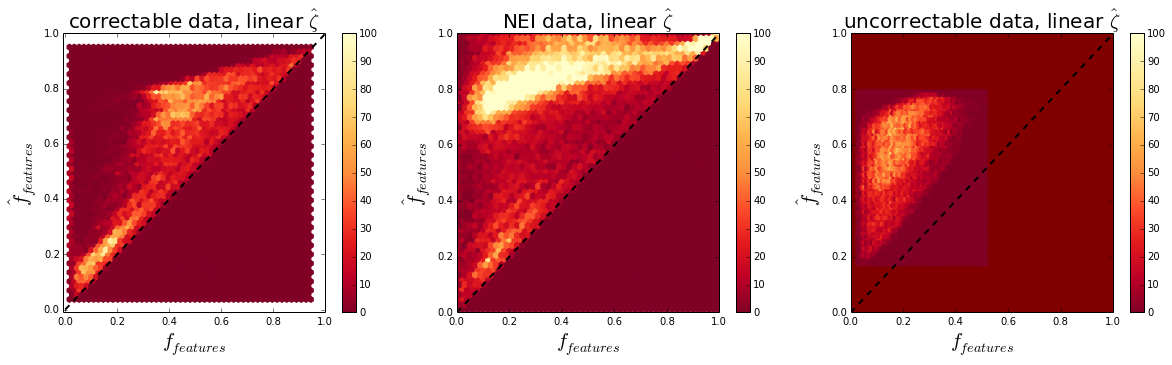

In [18]:
# 2D histogram of new p_features distribution
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
hex1 = ax1.hexbin(old_votes[correctable],new_c, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0,vmax=100)
ax1.set_xlabel(r'$f_{features}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{features}$',fontsize=20)
cb1 = plt.colorbar(hex1)
ax1.set_title('correctable data, linear $\hat \zeta$',fontsize=20)

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > 0.3
# Lower right = depressed p_features for z < 0.3

ax1.plot([0,1],[0,1],color='k',lw=2,ls='--')

# Try it with Mel's new function
ax2 = fig.add_subplot(132)
hex2 = ax2.hexbin(old_votes[nei],new_nei, cmap=plt.cm.YlOrRd_r,gridsize=50,vmax=100)
ax2.set_xlabel(r'$f_{features}$',fontsize=20)
ax2.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
cb2 = plt.colorbar(hex2)
ax2.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax2.set_title('NEI data, linear $\hat \zeta$',fontsize=20)

ax3 = fig.add_subplot(133)
hex3 = ax3.hexbin(old_votes[uncorrectable],new_unc, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0, vmax=100)
ax3.set_xlabel(r'$f_{features}$',fontsize=20)
ax3.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
cb3 = plt.colorbar(hex3)
ax3.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax3.set_title('uncorrectable data, linear $\hat \zeta$',fontsize=20)
ax3.set_axis_bgcolor('#800000')

